<a href="https://colab.research.google.com/github/vikram0230/Natural-Image-Classification/blob/master/natural_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import zipfile
import os
from keras.layers import Dense,Flatten,MaxPool2D,Conv2D,Dropout,GlobalAveragePooling2D
from keras.losses import binary_crossentropy,categorical_crossentropy
from keras.models import Model,Sequential
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from google.colab import files

# upload kaggle API key
files.upload()

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d prasunroy/natural-images

 94% 322M/342M [00:06<00:00, 27.2MB/s]
100% 342M/342M [00:07<00:00, 51.0MB/s]


In [5]:
!mkdir train

In [ ]:
!unzip natural-images.zip -d train

In [7]:
category = !ls train/natural_images/

In [8]:
classes = category[0].split()

In [9]:
train_df = pd.DataFrame(columns=['image','class'])
val_df = pd.DataFrame(columns=['image','class'])

In [10]:
for label in classes:
    images = !ls train/natural_images/{label}
    for image in images[:-30]:
      for i in image.split():  
        train_df = train_df.append({'image':'train/natural_images/'+label+'/'+i,'class':label},ignore_index=True)
    for image in images[-30:]:
      for i in image.split(): 
        val_df = val_df.append({'image':'train/natural_images/'+label+'/'+i,'class':label},ignore_index=True)

In [11]:
train_df.head()

,image,class
0,train/natural_images/airplane/airplane_0000.jpg,airplane
1,train/natural_images/airplane/airplane_0182.jpg,airplane
2,train/natural_images/airplane/airplane_0364.jpg,airplane
3,train/natural_images/airplane/airplane_0546.jpg,airplane
4,train/natural_images/airplane/airplane_0001.jpg,airplane


In [12]:
val_df.head()

,image,class
0,train/natural_images/airplane/airplane_0152.jpg,airplane
1,train/natural_images/airplane/airplane_0334.jpg,airplane
2,train/natural_images/airplane/airplane_0516.jpg,airplane
3,train/natural_images/airplane/airplane_0698.jpg,airplane
4,train/natural_images/airplane/airplane_0153.jpg,airplane


In [13]:
train_df.shape,val_df.shape

((5828, 2), (1071, 2))

In [19]:
train_datagen = ImageDataGenerator(
    rotation_range=40, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    rescale=1/255,
)

val_datagen = ImageDataGenerator(
    rescale=1/255
)

In [20]:
train_generator = train_datagen.flow_from_dataframe(train_df, x_col='image',y_col='class',classes=classes)
val_generator = val_datagen.flow_from_dataframe(val_df,x_col='image',y_col='class',classes=classes)

Found 5828 validated image filenames belonging to 8 classes.
Found 1071 validated image filenames belonging to 8 classes.


In [50]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2,preprocess_input

In [22]:
inceptionresnet = InceptionResNetV2(include_top=False, input_shape=(256,256,3),classes=8)

219062272/219055592 [==============================] - 1s 0us/step


In [23]:
inceptionresnet.trainable = False

In [24]:
last_layer = inceptionresnet.layers[-1].output

In [25]:
x = GlobalAveragePooling2D()(last_layer)
x = Dense(8,activation='softmax')(x)

In [26]:
model = Model(inceptionresnet.inputs,x)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [27]:
model.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),metrics=['acc'])

In [ ]:
history = model.fit(train_generator,epochs=3,validation_data=val_generator)

Epoch 1/3
183/183 [==============================] - 2036s 11s/step - loss: 1.5050 - acc: 0.5187 - val_loss: 0.3640 - val_acc: 0.9813
Epoch 2/3
183/183 [==============================] - 2021s 11s/step - loss: 0.2738 - acc: 0.9747 - val_loss: 0.1132 - val_acc: 0.9944
Epoch 3/3
183/183 [==============================] - 2021s 11s/step - loss: 0.1098 - acc: 0.9859 - val_loss: 0.0588 - val_acc: 0.9963


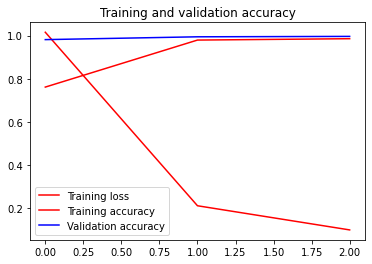

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
# model.save_weights('natural_images_inceptionresnet.h5')

In [ ]:
# files.download('natural_images_inceptionresnet.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
from random import randint
from keras.preprocessing.image import load_img,img_to_array

car


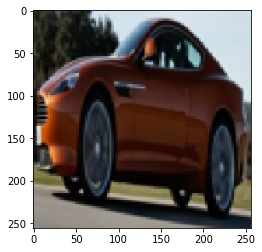

In [51]:
index = randint(1,val_df.shape[0])
image = val_df.iloc[index]
img = load_img(image.image,target_size=(256,256))
plt.imshow(img)

In [ ]:
img_tensor = img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

prediction = model.predict(img_tensor)
classes[np.argmax(prediction)]